In [40]:
import networkx as nx
import torch
import os
import pandas as pd
from torch_geometric.data import Data
import numpy as np
from dateutil.parser import parse
from torch.utils.tensorboard import SummaryWriter

np.random.seed(42)

In [145]:
import pandas as pd
from torch_geometric.data import Data
import torch

# Step 1: Read the CSV
csv_file = 'nfl-game-info.csv'  # Replace with your actual file path
df = pd.read_csv(csv_file)

# Step 2: Encode teams as nodes
teams = pd.concat([df['Home Team'], df['Away Team']]).unique()
team_to_index = {team: idx for idx, team in enumerate(teams)}

# Map teams to indices
df['home_team_idx'] = df['Home Team'].map(team_to_index)
df['away_team_idx'] = df['Away Team'].map(team_to_index)

# Step 3: Create edges and edge attributes
# Edge index: (source, target) pairs
edge_index = torch.tensor(
    [df['home_team_idx'].values, df['away_team_idx'].values], dtype=torch.long
)

# Fill missing values and convert to numeric
df['Home Score'] = pd.to_numeric(df['Home Score'], errors='coerce').fillna(0)  # Replace NaN with 0 or other value
df['Away Score'] = pd.to_numeric(df['Away Score'], errors='coerce').fillna(0)
df['Overtime?'] = df['Overtime?'].map({True: 1, False: 0}).fillna(0)  # Convert boolean to 1/0
df['Playoff Game?'] = df['Playoff Game?'].map({True: 1, False: 0}).fillna(0)  # Convert boolean to 1/0

# Edge attributes: Scores, flags, etc.
# Here, we're including Home Score, Away Score, Overtime, and Playoff Game
# edge_attr = torch.tensor(
#     df[['Home Score', 'Away Score', 'Overtime?', 'Playoff Game?']].values, dtype=torch.float
# )
df['Home Win'] = (df['Home Score'] > df['Away Score']).astype(float)  # 1 if home team wins
df['Away Win'] = (df['Away Score'] > df['Home Score']).astype(float)  # 1 if away team wins

# Edge attributes: Replace scores with binary outcomes, keep other features as is
edge_attr = torch.tensor(
    df[['Home Win', 'Away Win', 'Overtime?', 'Playoff Game?']].values,
    dtype=torch.float
)

# Convert dates to a numeric format
dates = pd.to_datetime(df['Date']).values
# dates_tensor = torch.tensor([date.timestamp() for date in dates], dtype=torch.float)
dates_tensor = torch.tensor(
    [pd.Timestamp(date).timestamp() for date in dates], dtype=torch.float
)

# Step 4: Create the Data object
data = Data(
    edge_index=edge_index,
    edge_attr=torch.cat([edge_attr, dates_tensor.unsqueeze(1)], dim=1),
    num_nodes=len(teams)
)

# Step 5: Partition the data by date
# Convert dates back to pandas datetime for filtering
date_series = pd.to_datetime(df['Date'])

# Assuming `date_series` is a pandas Series of game dates (already processed as datetime)
seasons = range(2004, 2024)  # Example seasons (adjust as needed)

train_masks = []
test_masks = []

# for season_start in seasons:
#     # Define training and testing date ranges for the season
#     train_start = pd.Timestamp(f'{season_start}-09-01')
#     train_end = pd.Timestamp(f'{season_start + 1}-01-31')
#     test_start = pd.Timestamp(f'{season_start+1}-01-01')
#     test_end = pd.Timestamp(f'{season_start+1}-03-01')
    
#     # Create masks for the current season
#     train_mask = (date_series >= train_start) & (date_series <= train_end)
#     test_mask = (date_series >= test_start) & (date_series <= test_end)
    
#     # Append the masks to the lists
#     train_masks.append(train_mask)
#     test_masks.append(test_mask)

# # Combine all masks
# final_train_mask = pd.concat(train_masks, axis=1).any(axis=1)
# final_test_mask = pd.concat(test_masks, axis=1).any(axis=1)

# # Apply masks to split the edges and edge attributes
# train_data = Data(
#     edge_index=edge_index[:, final_train_mask.values],
#     edge_attr=edge_attr[final_train_mask.values],
#     num_nodes=len(teams)
# )

# test_data = Data(
#     edge_index=edge_index[:, final_test_mask.values],
#     edge_attr=edge_attr[final_test_mask.values],
#     num_nodes=len(teams)
# )

# Define your train and test date ranges
train_start, train_end = pd.Timestamp('2018-01-01'), pd.Timestamp('2020-03-01')
test_start, test_end = pd.Timestamp('2020-04-01'), pd.Timestamp('2024-12-31')

# Create masks for train and test edges
train_mask = (date_series >= train_start) & (date_series <= train_end)
test_mask = (date_series >= test_start) & (date_series <= test_end)

# Apply masks to split the edges and edge attributes
train_data = Data(
    edge_index=edge_index[:, train_mask.values],
    edge_attr=edge_attr[train_mask.values],
    num_nodes=len(teams)
)

test_data = Data(
    edge_index=edge_index[:, test_mask.values],
    edge_attr=edge_attr[test_mask.values],
    num_nodes=len(teams)
)

# # Output the results
# print(f"Train Data: {train_data}")
# print(f"Test Data: {test_data}")


In [101]:
# print a sample edge embedding
print(train_data.edge_attr[0])

tensor([0., 1., 0., 0.])


In [113]:
from torch_geometric.nn import GATConv
from torch_geometric.data import Data, DataLoader
from torch_geometric.utils import to_networkx
import torch.nn.functional as F

In [146]:
num_nodes = len(teams)
node_feature_dim = 64
node_features = torch.randn((num_nodes, node_feature_dim), dtype=torch.float,)

# # RESIDUALS!
class GATModel(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, heads=8, dropout=0.6):
        super(GATModel, self).__init__()
        self.dropout = dropout
        self.num_layers = num_layers
        self.heads = heads
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.in_channels = in_channels

        # Define GAT layers
        self.convs = torch.nn.ModuleList()
        self.convs.append(GATConv(in_channels, hidden_channels, heads=heads, concat=True, dropout=dropout))

        for _ in range(num_layers - 2):
            self.convs.append(GATConv(hidden_channels * heads, hidden_channels, heads=heads, concat=True, dropout=dropout))

        self.convs.append(GATConv(hidden_channels * heads, out_channels, heads=1, concat=False, dropout=dropout))

        self.bns = torch.nn.ModuleList([
            torch.nn.BatchNorm1d(hidden_channels * heads) for _ in range(num_layers - 1)
        ])

        # Linear projection for residual connections (if dimensions don't match)
        self.residual_proj = torch.nn.ModuleList([
            torch.nn.Linear(in_channels if i == 0 else hidden_channels * heads, hidden_channels * heads) 
            for i in range(num_layers - 1)
        ])

    def forward(self, x, edge_index):
        for i, conv in enumerate(self.convs[:-1]):
            residual = x
            x = conv(x, edge_index)
            x = self.bns[i](x)
            x = F.elu(x)
            if residual.size(-1) != x.size(-1):
                residual = self.residual_proj[i](residual)

            x = x + residual    # Add residual connection
            x = F.dropout(x, p=self.dropout, training=self.training)  # Dropout
        x = self.convs[-1](x, edge_index)
        return x

    def encode(self, x, edge_index):
        return self.forward(x, edge_index)

    def decode(self, z, edge_index):
        # Use dot product to predict if an edge exists
        src, dst = edge_index
        return (z[src] * z[dst]).sum(dim=1)
    
class GATModelWithOutcome(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, num_layers=3, heads=8, dropout=0.6):
        super().__init__()
        self.dropout = dropout
        self.num_layers = num_layers
        self.heads = heads
        self.hidden_channels = hidden_channels
        self.out_channels = out_channels
        self.in_channels = in_channels
        self.gat = GATModel(
            in_channels=in_channels,
            hidden_channels=hidden_channels,
            out_channels=out_channels,
            num_layers=num_layers,
            heads=heads,
            dropout=dropout
        )
        self.mlp = torch.nn.Sequential(
            torch.nn.Linear(2 * out_channels + 4, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 1)  # Output score for home team win probability
        )

    def encode(self, x, edge_index):
        return self.gat.encode(x, edge_index)

    def decode(self, z, edge_index, edge_features):
        # Combine node embeddings with edge features
        src, dst = edge_index
        combined_features = torch.cat([z[src], z[dst], edge_features], dim=1)
        return self.mlp(combined_features).squeeze(-1)  # Output scalar score

# model = GATModel(in_channels=node_feature_dim, hidden_channels=32, out_channels=16, num_layers=4)
# 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# set to mps if mps is available
# device = torch.device('mps' if torch.backends.mps.is_available() else 'cpu')
print(device)
# model = model.to(device)
# data = data.to(device)
# node_features = node_features.to(device)

# with torch.no_grad():
#     embeddings = model(node_features, data.edge_index)

# print("GAT Embeddings:")
# print(embeddings)

cpu


In [147]:
import torch.nn.functional as F
from torch_geometric.utils import negative_sampling, train_test_split_edges

In [173]:
# Initialize the model
in_channels = node_features.size(1)  # Assuming you use random features as before
hidden_channels = 32
out_channels = 16
model = GATModelWithOutcome(in_channels=in_channels, hidden_channels=hidden_channels, out_channels=out_channels, num_layers=5).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)

In [149]:
import time
import torch
from torch.optim import Adam
from sklearn.metrics import roc_auc_score

In [174]:
patience = 100  # Number of epochs to wait before stopping if no improvement
patience_counter = 0
best_val_loss = 0

In [175]:
df['Home Win'] = (df['Home Score'] > df['Away Score']).astype(float)  # Binary outcome for training
edge_labels = torch.tensor(df['Home Win'].values, dtype=torch.float, device=device)  # Labels for all edges

In [176]:
# Training loop

timestr = time.strftime("%Y%m%d-%H%M%S") + "_" + 'GAT' + f'_layers_{model.num_layers}_heads_{model.heads}_hidden_{model.hidden_channels}_dropout_{model.dropout}'
writer = SummaryWriter(log_dir=f'./Graph/{timestr}')
# Split the original training data further into train and validation
# val_start, val_end = pd.Timestamp('2019-08-01'), pd.Timestamp('2020-03-01')  # Example validation range
# val_mask = (date_series >= val_start) & (date_series <= val_end)
# train_mask = ~val_mask & (date_series >= train_start) & (date_series <= train_end)

# # Create validation and train Data objects
# val_data = Data(
#     edge_index=edge_index[:, val_mask.values],
#     edge_attr=edge_attr[val_mask.values],
#     num_nodes=len(teams)
# ).to(device)

train_data = Data(
    edge_index=edge_index[:, train_mask.values],
    edge_attr=edge_attr[train_mask.values],
    num_nodes=len(teams)
).to(device)

# Training loop with validation
best_val_auc = 0
best_model = None
epochs = 10000
# Training Loop
for epoch in range(epochs):
    model.train()
    optimizer.zero_grad()

    # Node embeddings
    node_features = torch.randn(train_data.num_nodes, node_feature_dim, device=device)  # Replace with actual features
    z = model.encode(node_features, train_data.edge_index)

    # Predict game outcomes
    edge_scores = model.decode(z, train_data.edge_index, train_data.edge_attr)

    # Binary cross-entropy loss
    loss = F.binary_cross_entropy_with_logits(edge_scores, edge_labels[train_mask])
    writer.add_scalar('Loss/train', loss, epoch)
    acc = ((torch.sigmoid(edge_scores) > 0.5).float() == edge_labels[train_mask]).float().mean()
    writer.add_scalar('Accuracy/train', acc, epoch)
    loss.backward()
    optimizer.step()

    # Validation and testing
    # model.eval()
    # with torch.no_grad():
    #     val_edge_scores = model.decode(z, val_data.edge_index, val_data.edge_attr)
    #     val_probs = torch.sigmoid(val_edge_scores)  # Probability of home win
    #     val_preds = (val_probs > 0.5).float()  # Predicted winners
    #     val_accuracy = (val_preds == edge_labels[val_mask]).float().mean().item()

    # Print metrics
    # print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, Val Accuracy: {val_accuracy:.4f}")

    # Print metrics
    if (epoch + 1) % 100 == 0:
        print(
            f"Epoch {epoch+1}/{epochs}, Loss: {loss.item():.4f}, "
        )

# Load the best model

# Test set evaluation
with torch.no_grad():
    # Compute node embeddings for the test graph
    test_z = model.encode(node_features, test_data.edge_index)
    
    # Predict scores for positive edges (test edges)
    test_edge_scores = model.decode(test_z, test_data.edge_index, test_data.edge_attr)
    test_edge_labels = torch.ones(test_data.edge_index.size(1), device=device)  # Positive labels for test edges

    # Generate negative edges for testing
    num_test_edges = test_data.edge_index.size(1)
    test_neg_edge_index = torch.randint(0, test_data.num_nodes, (2, num_test_edges), device=device)
    test_neg_edge_features = torch.zeros(num_test_edges, test_data.edge_attr.size(1), device=device)  # Dummy edge features for negatives
    test_neg_edge_scores = model.decode(test_z, test_neg_edge_index, test_neg_edge_features)
    test_neg_edge_labels = torch.zeros(num_test_edges, device=device)  # Negative labels for test edges

    # Combine positive and negative edges
    test_all_scores = torch.cat([test_edge_scores, test_neg_edge_scores], dim=0)
    test_all_labels = torch.cat([test_edge_labels, test_neg_edge_labels], dim=0)

    # Convert scores to probabilities and calculate predictions
    test_probs = torch.sigmoid(test_all_scores).cpu().numpy()  # Probabilities
    test_preds = (test_probs > 0.5).astype(int)  # Binary predictions
    test_labels = test_all_labels.cpu().numpy()  # Ground truth labels

    # Compute evaluation metrics
    test_accuracy = (test_preds == test_labels).mean()  # Accuracy
    test_roc_auc = roc_auc_score(test_labels, test_probs)  # ROC AUC score

# Print test metrics
print(f"Test set ROC AUC: {test_roc_auc:.4f}")
print(f"Test set accuracy: {test_accuracy:.4f}")


# print(f"Best Validation ROC AUC: {best_val_auc:.4f}")


Epoch 100/10000, Loss: 0.7109, 
Epoch 200/10000, Loss: 1.1435, 
Epoch 300/10000, Loss: 0.6590, 
Epoch 400/10000, Loss: 0.6650, 
Epoch 500/10000, Loss: 0.5890, 
Epoch 600/10000, Loss: 0.6114, 
Epoch 700/10000, Loss: 0.7600, 
Epoch 800/10000, Loss: 0.5131, 
Epoch 900/10000, Loss: 0.5354, 
Epoch 1000/10000, Loss: 0.4383, 
Epoch 1100/10000, Loss: 0.3645, 
Epoch 1200/10000, Loss: 0.4590, 
Epoch 1300/10000, Loss: 0.4452, 
Epoch 1400/10000, Loss: 0.2393, 
Epoch 1500/10000, Loss: 0.2200, 
Epoch 1600/10000, Loss: 0.2642, 
Epoch 1700/10000, Loss: 0.2075, 
Epoch 1800/10000, Loss: 0.1441, 
Epoch 1900/10000, Loss: 0.1035, 
Epoch 2000/10000, Loss: 0.1556, 
Epoch 2100/10000, Loss: 0.0955, 
Epoch 2200/10000, Loss: 0.0733, 
Epoch 2300/10000, Loss: 0.0531, 
Epoch 2400/10000, Loss: 0.0753, 
Epoch 2500/10000, Loss: 0.0614, 
Epoch 2600/10000, Loss: 0.0296, 
Epoch 2700/10000, Loss: 0.0316, 
Epoch 2800/10000, Loss: 0.0236, 
Epoch 2900/10000, Loss: 0.0342, 
Epoch 3000/10000, Loss: 0.0226, 
Epoch 3100/10000, L

In [152]:
with torch.no_grad():
    embeddings = model.encode(node_features, data.edge_index)

TypeError: Axes3D.text() missing 1 required positional argument: 's'

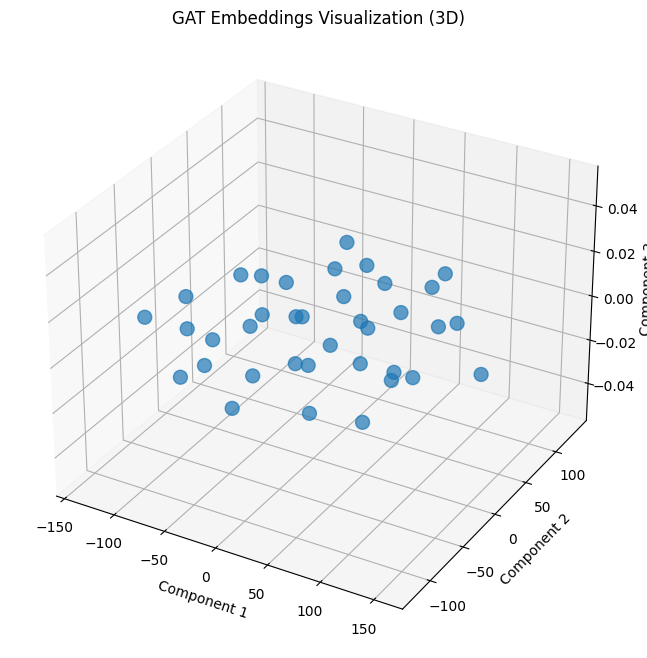

In [154]:
# Assuming `embeddings` is a tensor of shape [num_nodes, embedding_dim]
embeddings_np = embeddings.cpu().numpy()  # Convert to NumPy for compatibility with sklearn
tsne = TSNE(n_components=3, random_state=0)
reduced_embeddings = tsne.fit_transform(embeddings_np)

from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plotting

# Assuming `reduced_embeddings` has 3 dimensions (from t-SNE with `n_components=3`)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Create the 3D scatter plot
ax.scatter(
    reduced_embeddings[:, 0],  # X-axis
    reduced_embeddings[:, 1],  # Y-axis
    # reduced_embeddings[:, 2],  # Z-axis
    s=100, alpha=0.7
)

ax.set_title("GAT Embeddings Visualization (3D)")
ax.set_xlabel("Component 1")
ax.set_ylabel("Component 2")
ax.set_zlabel("Component 3")

for i, team in enumerate(teams):
    ax.text(
        reduced_embeddings[i, 0],
        reduced_embeddings[i, 1],
        # reduced_embeddings[i, 2],
        team,
        fontsize=9
    )

plt.show()

plt.show()